In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-01 23:57:18.999566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 23:57:18.999598: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.3)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="gauss", threshold=0.5,
                                  noise_distribution="gauss", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:100096, :], y[:100096]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    """Map optimizer objects to optimizer names, e.g 'sgd', 'rmsprop', etc."""
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/41


2022-05-01 23:57:21.522185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 23:57:21.522226: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 23:57:21.522255: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-01 23:57:21.522587: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


391/391 [==============================] - 2s 3ms/step - loss: 0.6868 - accuracy: 0.5570 - auc: 0.5793 - val_loss: 0.6521 - val_accuracy: 0.6536 - val_auc: 0.7109
Epoch 2/41
391/391 [==============================] - 1s 2ms/step - loss: 0.6601 - accuracy: 0.6033 - auc: 0.6456 - val_loss: 0.6207 - val_accuracy: 0.7206 - val_auc: 0.7962
Epoch 3/41
391/391 [==============================] - 1s 2ms/step - loss: 0.6280 - accuracy: 0.6538 - auc: 0.7134 - val_loss: 0.5800 - val_accuracy: 0.7685 - val_auc: 0.8537
Epoch 4/41
391/391 [==============================] - 1s 2ms/step - loss: 0.5917 - accuracy: 0.6964 - auc: 0.7676 - val_loss: 0.5292 - val_accuracy: 0.8037 - val_auc: 0.8933
Epoch 5/41
391/391 [==============================] - 1s 2ms/step - loss: 0.5507 - accuracy: 0.7328 - auc: 0.8096 - val_loss: 0.4722 - val_accuracy: 0.8335 - val_auc: 0.9213
Epoch 6/41
391/391 [==============================] - 1s 2ms/step - loss: 0.5042 - accuracy: 0.7677 - auc: 0.8479 - val_loss: 0.4136 - val_ac

391/391 [==============================] - 1s 2ms/step - loss: 0.3519 - accuracy: 0.8513 - auc: 0.9293 - val_loss: 0.2472 - val_accuracy: 0.9172 - val_auc: 0.9774
Epoch 6/41
391/391 [==============================] - 1s 2ms/step - loss: 0.3209 - accuracy: 0.8636 - auc: 0.9395 - val_loss: 0.2167 - val_accuracy: 0.9243 - val_auc: 0.9810
Epoch 7/41
391/391 [==============================] - 1s 2ms/step - loss: 0.2973 - accuracy: 0.8738 - auc: 0.9472 - val_loss: 0.1960 - val_accuracy: 0.9298 - val_auc: 0.9833
Epoch 8/41
391/391 [==============================] - 1s 2ms/step - loss: 0.2796 - accuracy: 0.8814 - auc: 0.9528 - val_loss: 0.1811 - val_accuracy: 0.9334 - val_auc: 0.9850
Epoch 9/41
391/391 [==============================] - 1s 2ms/step - loss: 0.2645 - accuracy: 0.8876 - auc: 0.9575 - val_loss: 0.1700 - val_accuracy: 0.9364 - val_auc: 0.9862
Epoch 10/41
391/391 [==============================] - 1s 2ms/step - loss: 0.2540 - accuracy: 0.8924 - auc: 0.9607 - val_loss: 0.1620 - val_a

391/391 [==============================] - 1s 2ms/step - loss: 0.2287 - accuracy: 0.9050 - auc: 0.9681 - val_loss: 0.1447 - val_accuracy: 0.9437 - val_auc: 0.9892
Epoch 10/41
391/391 [==============================] - 1s 2ms/step - loss: 0.2188 - accuracy: 0.9086 - auc: 0.9708 - val_loss: 0.1401 - val_accuracy: 0.9456 - val_auc: 0.9896
Epoch 11/41
391/391 [==============================] - 1s 2ms/step - loss: 0.2116 - accuracy: 0.9111 - auc: 0.9726 - val_loss: 0.1366 - val_accuracy: 0.9466 - val_auc: 0.9900
Epoch 12/41
391/391 [==============================] - 1s 2ms/step - loss: 0.2066 - accuracy: 0.9138 - auc: 0.9739 - val_loss: 0.1338 - val_accuracy: 0.9472 - val_auc: 0.9903
Epoch 13/41
391/391 [==============================] - 1s 2ms/step - loss: 0.1975 - accuracy: 0.9177 - auc: 0.9762 - val_loss: 0.1312 - val_accuracy: 0.9480 - val_auc: 0.9905
Epoch 14/41
391/391 [==============================] - 1s 2ms/step - loss: 0.1932 - accuracy: 0.9195 - auc: 0.9772 - val_loss: 0.1293 - v

391/391 [==============================] - 1s 2ms/step - loss: 0.2107 - accuracy: 0.9153 - auc: 0.9731 - val_loss: 0.1326 - val_accuracy: 0.9473 - val_auc: 0.9907
Epoch 14/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2041 - accuracy: 0.9191 - auc: 0.9746 - val_loss: 0.1295 - val_accuracy: 0.9481 - val_auc: 0.9909
Epoch 15/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1975 - accuracy: 0.9207 - auc: 0.9763 - val_loss: 0.1273 - val_accuracy: 0.9488 - val_auc: 0.9911
Epoch 16/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1910 - accuracy: 0.9241 - auc: 0.9777 - val_loss: 0.1254 - val_accuracy: 0.9489 - val_auc: 0.9913
Epoch 17/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1850 - accuracy: 0.9280 - auc: 0.9790 - val_loss: 0.1242 - val_accuracy: 0.9491 - val_auc: 0.9914
Epoch 18/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1828 - accuracy: 0.9280 - auc: 0.9796 - val_loss: 0.1232 - v

Epoch 60/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1402 - accuracy: 0.9452 - auc: 0.9878 - val_loss: 0.1165 - val_accuracy: 0.9496 - val_auc: 0.9921
Epoch 61/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1397 - accuracy: 0.9452 - auc: 0.9879 - val_loss: 0.1163 - val_accuracy: 0.9492 - val_auc: 0.9921
Epoch 62/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1390 - accuracy: 0.9456 - auc: 0.9880 - val_loss: 0.1162 - val_accuracy: 0.9499 - val_auc: 0.9921
Epoch 63/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1390 - accuracy: 0.9444 - auc: 0.9880 - val_loss: 0.1161 - val_accuracy: 0.9498 - val_auc: 0.9921
Epoch 64/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1386 - accuracy: 0.9454 - auc: 0.9881 - val_loss: 0.1160 - val_accuracy: 0.9496 - val_auc: 0.9921
Epoch 65/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1366 - accuracy: 0.9466 - auc: 0.9885 - val_loss

391/391 [==============================] - 1s 2ms/step - loss: 0.1645 - accuracy: 0.9376 - auc: 0.9831 - val_loss: 0.1193 - val_accuracy: 0.9487 - val_auc: 0.9919
Epoch 22/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1612 - accuracy: 0.9387 - auc: 0.9838 - val_loss: 0.1190 - val_accuracy: 0.9487 - val_auc: 0.9920
Epoch 23/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1605 - accuracy: 0.9386 - auc: 0.9839 - val_loss: 0.1189 - val_accuracy: 0.9488 - val_auc: 0.9920
Epoch 24/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1575 - accuracy: 0.9395 - auc: 0.9846 - val_loss: 0.1187 - val_accuracy: 0.9487 - val_auc: 0.9920
Epoch 25/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1577 - accuracy: 0.9389 - auc: 0.9845 - val_loss: 0.1184 - val_accuracy: 0.9484 - val_auc: 0.9920
Epoch 26/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1549 - accuracy: 0.9407 - auc: 0.9850 - val_loss: 0.1183 - v

Epoch 68/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1308 - accuracy: 0.9468 - auc: 0.9895 - val_loss: 0.1136 - val_accuracy: 0.9493 - val_auc: 0.9922
Epoch 69/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1317 - accuracy: 0.9464 - auc: 0.9892 - val_loss: 0.1136 - val_accuracy: 0.9493 - val_auc: 0.9922
Epoch 70/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1307 - accuracy: 0.9468 - auc: 0.9894 - val_loss: 0.1135 - val_accuracy: 0.9495 - val_auc: 0.9922
Epoch 71/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1319 - accuracy: 0.9461 - auc: 0.9892 - val_loss: 0.1135 - val_accuracy: 0.9493 - val_auc: 0.9922
Epoch 72/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1300 - accuracy: 0.9472 - auc: 0.9895 - val_loss: 0.1135 - val_accuracy: 0.9492 - val_auc: 0.9922
Epoch 73/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1295 - accuracy: 0.9474 - auc: 0.9896 - val_loss

391/391 [==============================] - 1s 2ms/step - loss: 0.1460 - accuracy: 0.9447 - auc: 0.9866 - val_loss: 0.1187 - val_accuracy: 0.9487 - val_auc: 0.9920
Epoch 30/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1451 - accuracy: 0.9444 - auc: 0.9869 - val_loss: 0.1185 - val_accuracy: 0.9487 - val_auc: 0.9920
Epoch 31/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1443 - accuracy: 0.9456 - auc: 0.9869 - val_loss: 0.1182 - val_accuracy: 0.9487 - val_auc: 0.9921
Epoch 32/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1427 - accuracy: 0.9460 - auc: 0.9873 - val_loss: 0.1181 - val_accuracy: 0.9488 - val_auc: 0.9921
Epoch 33/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1431 - accuracy: 0.9455 - auc: 0.9872 - val_loss: 0.1180 - val_accuracy: 0.9487 - val_auc: 0.9921
Epoch 34/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1423 - accuracy: 0.9454 - auc: 0.9874 - val_loss: 0.1176 - v

Epoch 76/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1269 - accuracy: 0.9476 - auc: 0.9900 - val_loss: 0.1131 - val_accuracy: 0.9487 - val_auc: 0.9922
Epoch 77/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1267 - accuracy: 0.9479 - auc: 0.9901 - val_loss: 0.1130 - val_accuracy: 0.9490 - val_auc: 0.9922
Epoch 78/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1280 - accuracy: 0.9476 - auc: 0.9898 - val_loss: 0.1130 - val_accuracy: 0.9489 - val_auc: 0.9922
Epoch 79/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1268 - accuracy: 0.9480 - auc: 0.9900 - val_loss: 0.1130 - val_accuracy: 0.9488 - val_auc: 0.9922
Epoch 80/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1264 - accuracy: 0.9479 - auc: 0.9901 - val_loss: 0.1130 - val_accuracy: 0.9490 - val_auc: 0.9922
Epoch 81/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1264 - accuracy: 0.9479 - auc: 0.9901 - val_loss

Epoch 2/3
12512/12512 [==============================] - 20s 2ms/step - loss: 0.1302 - accuracy: 0.9462 - auc: 0.9894 - val_loss: 0.1176 - val_accuracy: 0.9484 - val_auc: 0.9915
Epoch 3/3
12512/12512 [==============================] - 20s 2ms/step - loss: 0.1297 - accuracy: 0.9466 - auc: 0.9895 - val_loss: 0.1199 - val_accuracy: 0.9479 - val_auc: 0.9910
{'learning_rate': 0.0036, 'batch': 8, 'epoch': 1, 'optimizer': 'adam', 'best_loss': {'loss': 0.11758242547512054, 'epoch': 2}, 'best_auc': {'auc': 0.9916466474533081, 'epoch': 1}, 'best_accuracy': {'accuracy': 0.9483500123023987, 'epoch': 2}}
Epoch 1/4
12512/12512 [==============================] - 20s 2ms/step - loss: 0.3825 - accuracy: 0.8149 - auc: 0.9077 - val_loss: 0.1450 - val_accuracy: 0.9410 - val_auc: 0.9888
Epoch 2/4
12512/12512 [==============================] - 19s 2ms/step - loss: 0.1994 - accuracy: 0.9182 - auc: 0.9757 - val_loss: 0.1230 - val_accuracy: 0.9466 - val_auc: 0.9913
Epoch 3/4
12512/12512 [======================

Epoch 6/7
12512/12512 [==============================] - 25s 2ms/step - loss: 0.1385 - accuracy: 0.9440 - auc: 0.9884 - val_loss: 0.1212 - val_accuracy: 0.9471 - val_auc: 0.9910
Epoch 7/7
12512/12512 [==============================] - 25s 2ms/step - loss: 0.1370 - accuracy: 0.9451 - auc: 0.9885 - val_loss: 0.1235 - val_accuracy: 0.9474 - val_auc: 0.9911
{'learning_rate': 0.007, 'batch': 8, 'epoch': 4, 'optimizer': 'nadam', 'best_loss': {'loss': 0.11908825486898422, 'epoch': 3}, 'best_auc': {'auc': 0.9912974238395691, 'epoch': 3}, 'best_accuracy': {'accuracy': 0.9473999738693237, 'epoch': 5}}
Epoch 1/7
12512/12512 [==============================] - 22s 2ms/step - loss: 0.1546 - accuracy: 0.9385 - auc: 0.9857 - val_loss: 0.1260 - val_accuracy: 0.9466 - val_auc: 0.9910
Epoch 2/7
12512/12512 [==============================] - 21s 2ms/step - loss: 0.1449 - accuracy: 0.9422 - auc: 0.9873 - val_loss: 0.1279 - val_accuracy: 0.9483 - val_auc: 0.9904
Epoch 3/7
12512/12512 [======================

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/82
391/391 [==============================] - 2s 3ms/step - loss: 0.6528 - accuracy: 0.6120 - auc: 0.6613 - val_loss: 0.5737 - val_accuracy: 0.7876 - val_auc: 0.8738
Epoch 2/82
391/391 [==============================] - 1s 2ms/step - loss: 0.5602 - accuracy: 0.7221 - auc: 0.8000 - val_loss: 0.4424 - val_accuracy: 0.8605 - val_auc: 0.9417
Epoch 3/82
391/391 [==============================] - 1s 2ms/step - loss: 0.4553 - accuracy: 0.7932 - auc: 0.8787 - val_loss: 0.3097 - val_accuracy: 0.9079 - val_auc: 0.9733
Epoch 4/82
391/391 [==============================] - 1s 3ms/step - loss: 0.3638 - accuracy: 0.8426 - auc: 0.9236 - val_loss: 0.2223 - val_accuracy: 0.9305 - val_auc: 0.9847
Epoch 5/82
391/391 [==============================] - 1s 2ms/step - loss: 0.3043 - accuracy: 0.8720 - auc: 0.9455 - val_loss: 0.1761 - val_accuracy: 0.9413 - val_auc: 0.9884
Epoch 6/82
391/391 [==============================] - 1s 3ms/step - loss: 0.2647 - accuracy: 0.8906 - auc: 0.9584 - val_loss: 0.15

Epoch 48/82
391/391 [==============================] - 1s 2ms/step - loss: 0.1331 - accuracy: 0.9471 - auc: 0.9890 - val_loss: 0.1142 - val_accuracy: 0.9506 - val_auc: 0.9922
Epoch 49/82
391/391 [==============================] - 1s 2ms/step - loss: 0.1316 - accuracy: 0.9476 - auc: 0.9893 - val_loss: 0.1141 - val_accuracy: 0.9505 - val_auc: 0.9922
Epoch 50/82
391/391 [==============================] - 1s 2ms/step - loss: 0.1316 - accuracy: 0.9473 - auc: 0.9893 - val_loss: 0.1139 - val_accuracy: 0.9502 - val_auc: 0.9922
Epoch 51/82
391/391 [==============================] - 1s 2ms/step - loss: 0.1317 - accuracy: 0.9478 - auc: 0.9893 - val_loss: 0.1139 - val_accuracy: 0.9500 - val_auc: 0.9922
Epoch 52/82
391/391 [==============================] - 1s 2ms/step - loss: 0.1313 - accuracy: 0.9475 - auc: 0.9893 - val_loss: 0.1138 - val_accuracy: 0.9502 - val_auc: 0.9922
Epoch 53/82
391/391 [==============================] - 1s 2ms/step - loss: 0.1309 - accuracy: 0.9480 - auc: 0.9894 - val_loss

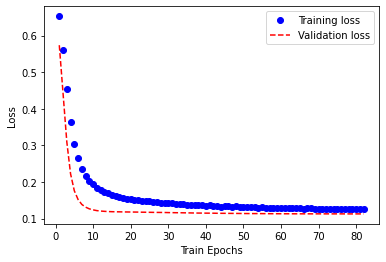

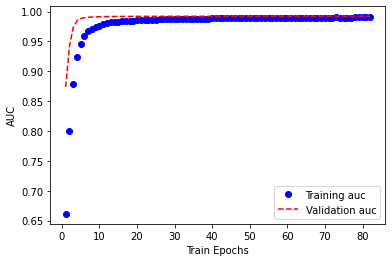

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

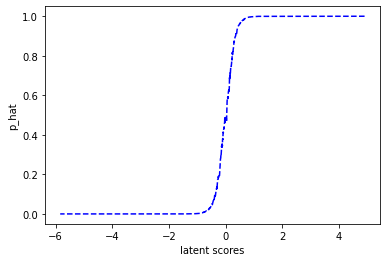

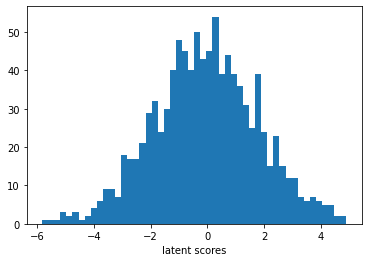

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

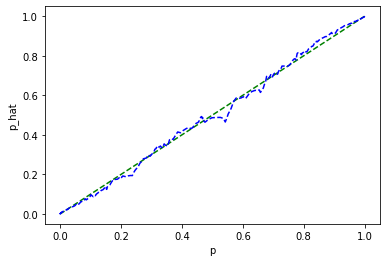

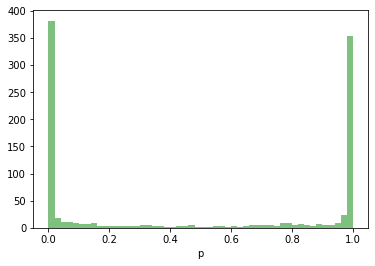

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

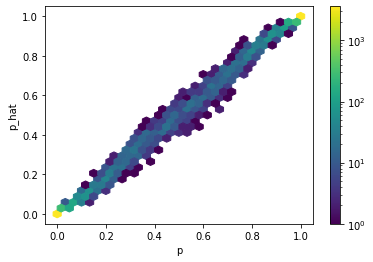

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

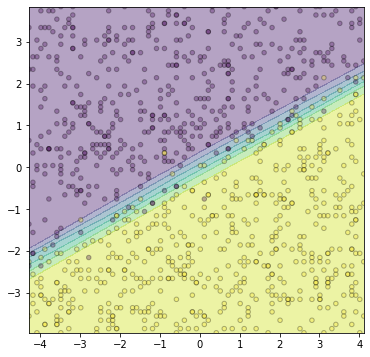

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 30)                330       
                                                                 
 dropout_72 (Dropout)        (None, 30)                0         
                                                                 
 dense_97 (Dense)            (None, 30)                930       
                                                                 
 dropout_73 (Dropout)        (None, 30)                0         
                                                                 
 dense_98 (Dense)            (None, 30)                930       
                                                                 
 dropout_74 (Dropout)        (None, 30)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.006,
 'batch': 256,
 'epoch': 59,
 'optimizer': 'sgd',
 'best_loss': {'loss': 0.11294324696063995, 'epoch': 82},
 'best_auc': {'auc': 0.9922204613685608, 'epoch': 56},
 'best_accuracy': {'accuracy': 0.9495000243186951, 'epoch': 46},
 'model': <keras.engine.sequential.Sequential at 0x7f7bedf5e700>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.12017231434583664, 'epoch': 41},
  'best_auc': {'auc': 0.9917749762535095, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9485499858856201, 'epoch': 40}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.1168375015258789, 'epoch': 41},
  'best_auc': {'auc': 0.9920042753219604, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9496999979019165, 'epoch': 39}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.11544738709926605, 'epoch': 41},
  'best_auc': {'auc': 0.9921135306358337, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9508500099182129, 'epoch': 38}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 59,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.11460031569004059, 'epoch': 83},
  'best_auc': {'auc': 0.9921402335166931, 'epoch': 82},
  'best_accura

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25